# GBRT con evaluación NDCG 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
from sklearn import preprocessing

%matplotlib inline

En los últimos experimentos se ha estado utilizando Mean Squared Error (MSE) para la medición del error de los rankeos pronosticados contra los observados. Para este experimento se ha implementado una medición de error para ranking más adecuada, llamada Normalized Discounted Cumulative Gain (NDCG), la cual es una medida muy popular para rankeo de páginas web.

In [2]:
def load_daytrips():
    path = r'D:\ownCloud\Documentos posgrado\Posgrado 2do semestre\Seminario investigacion\Experimental Data\Cd Mex\Movilidad\Hist Ecobici\ecobici.csv'
    trips = pd.read_csv(path,
                    parse_dates=['date_removed', 'date_arrived'],
                    infer_datetime_format=True,
                    low_memory=False)
    
    trips = trips.loc[trips['action'] != 'C  ']

    # Find the start date
    ind = pd.DatetimeIndex(trips.date_arrived)
    trips['date'] = ind.date.astype('datetime64')
    trips['hour'] = ind.hour

    # Count trips by date
    by_date = trips.pivot_table('bike',aggfunc='count',
                            index='date',
                            columns='station_arrived', )

    # add a flag indicating weekend
    by_date['weekend'] = (by_date.index.dayofweek >= 5)
    
    by_date_weekday = by_date[by_date['weekend'] == False]

    mavg_wd = by_date_weekday.sum(axis=1).rolling(window=20,center=False).mean()
    mstd_wd = by_date_weekday.sum(axis=1).rolling(window=20,center=False).std()

    black_list = by_date_weekday.sum(axis=1)[by_date_weekday.sum(axis=1) <= mavg_wd-2*mstd_wd].index

    by_date_weekend = by_date[by_date['weekend'] == True]

    mavg_we = by_date_weekend.sum(axis=1).rolling(window=20,center=False).mean()
    mstd_we = by_date_weekend.sum(axis=1).rolling(window=20,center=False).std()

    black_list = black_list.union(by_date_weekend.sum(axis=1)[by_date_weekend.sum(axis=1) <= mavg_we-2*mstd_we].index)
    
    # remove those values on the blacklist
    by_date = by_date.fillna(0)
    by_date = by_date.loc[~by_date.index.isin(black_list)]
    
    return by_date

In [3]:
by_date = load_daytrips()

station_phase_path = r'C:\Users\ghost\Google Drive\JairCastruitaGastelum\Progress Reports\Clustering_ECOBICI\DATA\ecobiciFases.csv'
station_phase = pd.read_csv(station_phase_path,header=None)
station_phase.columns = ['station','phase']

by_date.drop([col for col in list(by_date.columns.values) if col not in station_phase[station_phase['phase'] <= 1]['station'].values or col >= 260], 
        axis=1, inplace=True)

# Keep only weekdays to make a more stable count signal
by_date = by_date[by_date.index.dayofweek < 5]

phase1 = by_date['2010-02-20':'2012-10-29'].copy()

C:\Users\ghost\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Se obtienen las secciones para rank diversity

In [4]:
data = dict([(r[0], list(phase1.columns[np.argsort(list(r)[1: ])[::-1]])) \
        for r in list(phase1.to_records())])
    
dr = pd.DataFrame.from_dict(data, orient='index', dtype=None)
dr = dr.sort_index()

head = np.unique(dr[[0]])

tail = np.setdiff1d(dr[89].unique(), dr[0].unique())

body = np.setdiff1d(dr[50].unique(), head)
body = np.setdiff1d(body, tail)

In [5]:
print 'Head:',head,'\n'
print 'Body:',body,'\n'
print 'Tail:',tail,'\n'

Head: [ 1  5 13 17 19 20 24 27 29 31 36 61 64 70 84 85] 

Body: [ 4  6  7 11 16 18 21 23 28 35 37 38 45 49 51 53 58 60 63 66 68 69 71 72 73
 75 76 78 79 83] 

Tail: [ 2  3  8  9 10 12 14 15 22 25 26 30 32 33 34 39 40 41 42 43 44 46 48 50 52
 54 55 57 59 62 65 67 77 80 81 82 86 87 88 89 90] 



In [6]:
phase_aux = phase1.transpose()
phase_transformed = pd.melt(phase_aux.reset_index(), id_vars=["station_arrived"], 
                  var_name="Date", value_name="Value").sort_values(["station_arrived",'Date'])

phase_transformed = phase_transformed.set_index('Date')
phase_transformed['weekday'] = phase_transformed.index.dayofweek
phase_transformed['rolling'] = phase_transformed.groupby('station_arrived')['Value'].apply(lambda x: x.rolling(window=10,
                                                                                                               center=False).mean())

In [7]:
phase_transformed['shift'] = phase_transformed.groupby('station_arrived')['Value'].shift(periods=1)

In [8]:
phase_transformed = phase_transformed.dropna()

In [9]:
def makeData(data):
    tdata = data.transpose()
    tdata_row = pd.melt(tdata.reset_index(), id_vars=["station_arrived"], 
                      var_name="Date", value_name="Rank")

    tdata_row = tdata_row.sort_values(["station_arrived",'Rank'])
    tdata_row = tdata_row.set_index('Date')

    return tdata_row

In [10]:
train = phase_transformed[:'2012-09-29']
test = phase_transformed['2012-09-29':]

In [11]:
rank1 = phase1.rank(axis='columns', ascending=True, method='first')

In [12]:
train_rank = rank1['2010-09-01':'2012-08-29']
test_rank = rank1['2012-08-29':]

In [13]:
train_rank_whole, test_rank_whole = makeData(train_rank), makeData(test_rank)

train = train.reset_index()
train_rank_whole = train_rank_whole.reset_index()

test = test.reset_index()
test_rank_whole = test_rank_whole.reset_index()

Se contruye el vector de características con el que se ajustará el modelo. Esta vez solo se ha optado por seleccionar dos características consideradas relevantes: día de la semana y media móvil. Se ha llegado a esta decisión por los resultados anteriormente obtenidos donde se apreciaba la alta correlación que existían entre las demás variables contruidas.

In [14]:
train_set = pd.merge(train, train_rank_whole, left_on=['Date','station_arrived'], right_on=['Date','station_arrived'])
X_train = train_set[['rolling','weekday']]
y_train = train_set[['Value']]

test_set = pd.merge(test, test_rank_whole, left_on=['Date','station_arrived'], right_on=['Date','station_arrived'])
X_test = test_set[['rolling','weekday']]
y_test = test_set[['Value']]

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

In [16]:
est = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01,
         max_depth=2, random_state=0, loss='ls').fit(X_train.values, y_train.values.flatten())

train_set['y_'] = est.predict(X_train.values)

In [17]:
train_set['y_rank'] = train_set.groupby('Date')['y_'].rank(ascending=True, method='first')

Normalized Discounted Cumulative Gain es la medida más adecuada al momento de medir la importancia de los elementos que obtuvieron el mayor rango, luego así, los de mayor importancia y cuyo rango está limitado en la escala [0-1] donde valores más acercados a 1 son más cercanos a la ordenación de rangos ideal:

http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf

Para ajustar los rangos a esta medida se invirtió la etiqueta en los rangos, ahora se asigna 1 a la estación con menor actividad durante el día y $n$ a la estación con mayor actividad, siendo $n$ en este caso la $n$-ésima estación contemplada en la ordenación.

In [18]:
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.

def ndcg_at_k(r, k, method=0):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [19]:
def ErrorRank(Sample_error):
    sns.set(style="ticks", palette="muted", color_codes=True)

    # Plot the period with horizontal boxes
    ax = sns.boxplot(x="NDCG", y="Diversity rank", data=Sample_error,
                     whis=np.inf, color="c")

    # Add in points to show each observation
    sns.stripplot(x="NDCG", y="Diversity rank", data=Sample_error,
                  jitter=True, size=3, color=".3", linewidth=0)

    ax.set_title('Box plot de errores con respecto a distribucion de rango')
    sns.despine(trim=True)

In [20]:
def SampledError(set_):
    Sample_error = pd.DataFrame({'Diversity rank' : [],'Error' : []})
    
    df = set_.groupby('Date').apply(lambda x: x.sort_values('Rank',ascending=False))
    del df['Date']
    df = df.reset_index()

    for i in range(100):
        sample_head = head[np.random.randint(len(head),size=10)]
        sample_body = body[np.random.randint(len(body),size=10)]
        sample_tail = tail[np.random.randint(len(tail),size=10)]
        
        sumHead = 0
        sumBody = 0
        sumTail = 0
        
        for d in df.Date.unique():
            
            #head
            rankhead = df[(df.Date == d) & (df['station_arrived'].isin(sample_head))]
            sumHead = sumHead + ndcg_at_k(rankhead['y_rank'].tolist(), len(rankhead['y_rank']))
            

            #body
            rankbody = df[(df.Date == d) & (df['station_arrived'].isin(sample_body))]
            sumBody = sumBody + ndcg_at_k(rankbody['y_rank'].tolist(), len(rankbody['y_rank']))
            

            #tail
            ranktail = df[(df.Date == d) & (df['station_arrived'].isin(sample_tail))]
            sumTail = sumTail + ndcg_at_k(ranktail['y_rank'].tolist(), len(ranktail['y_rank']))
            
        
        Sample_error = Sample_error.append(pd.DataFrame([['Head', sumHead/len(df.Date.unique())]],
                                                        columns=['Diversity rank','Error']),ignore_index=True)
            
        Sample_error = Sample_error.append(pd.DataFrame([['Body', sumBody/len(df.Date.unique())]], 
                                                        columns=['Diversity rank','Error']),ignore_index=True)
            
        Sample_error = Sample_error.append(pd.DataFrame([['Tail', sumTail/len(df.Date.unique())]], 
                                                        columns=['Diversity rank','Error']),ignore_index=True)
        
    return Sample_error

## Train

Se dejó un total de 490 días para el conjunto de entrenamiento y 21 para el de prueba: para cada día se realiza la regresión para cada estación y después son ordenadas de mayor a menor, una vez con un rango ordenado las estaciones son re-ordenadas respecto al rango real observado ese día aplicando NDCG sobre los conjuntos de head, body y tail por separado se obtienen 3 evaluaciones para cada uno de los conjuntos.

In [21]:
df = train_set.groupby('Date').apply(lambda x: x.sort_values('Rank',ascending=False))
del df['Date']
df = df.reset_index()

Sample_error = pd.DataFrame({'Diversity rank' : [],'NDCG' : []})

for d in df.Date.unique():
    rankhead = df[(df.Date == d) & (df['station_arrived'].isin(head))]
    Sample_error = Sample_error.append(pd.DataFrame([['Head', ndcg_at_k(rankhead['y_rank'].tolist(), len(rankhead['y_rank']))]], 
                                                        columns=['Diversity rank','NDCG']),ignore_index=True)
    rankbody = df[(df.Date == d) & (df['station_arrived'].isin(body))]
    Sample_error = Sample_error.append(pd.DataFrame([['Body', ndcg_at_k(rankbody['y_rank'].tolist(), len(rankbody['y_rank']))]], 
                                                        columns=['Diversity rank','NDCG']),ignore_index=True)
    ranktail = df[(df.Date == d) & (df['station_arrived'].isin(tail))]
    Sample_error = Sample_error.append(pd.DataFrame([['Tail', ndcg_at_k(ranktail['y_rank'].tolist(), len(ranktail['y_rank']))]], 
                                                        columns=['Diversity rank','NDCG']),ignore_index=True)

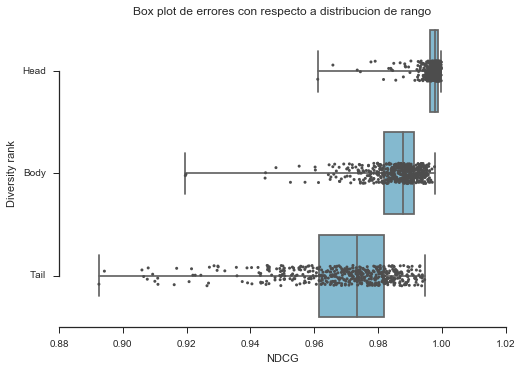

In [22]:
ErrorRank(Sample_error)

El gráfico anterior es un boxplot por categoría en relación a la evaluación obtenida con NDCG: aunque los valores están muy acercados aparentemente el uno del otro las medianas y los cuartiles parecen estar bien separados entre ellos.

In [23]:
import scipy.stats as stats

In [24]:
groups = Sample_error.groupby("Diversity rank").groups

In [25]:
# Etract diversity rank groups
NDCG_head = Sample_error.ix[groups["Head"]].NDCG.values
NDCG_body = Sample_error.ix[groups["Body"]].NDCG.values
NDCG_tail = Sample_error.ix[groups["Tail"]].NDCG.values

Lo que se desea hacer es probar que los valores de error difieren basados en las variables categóricas de rank diversity, para eso tenemos que comparar las medias de cada grupo de variable. El análisis de varianza o ANOVA es una prueba de inferencia estadística que permite el comparar múltiples grupos al mismo tiempo.

La prueba conocida como one-way ANOVA donde la media de algunas variables numéricas difieren sobre los niveles de una variable categórica. Esta prueba responde esencialmente la pregunta de: ¿Alguna de las medias en los grupos difiere de las demás? Para esta situación nos ayudará a responder si existe diferencia entre los errores obtenidos entre las diferentes variables categóricas entre el head, body y tail.

Afortunadamente la librería scipy de python tiene una función para realizar la prueba one-way ANOVA. Se puede acceder a esta herramienta mediante scipy.stats.f_oneway().

In [26]:
# Perform the ANOVA
stats.f_oneway(NDCG_head, NDCG_body, NDCG_tail)

F_onewayResult(statistic=677.0704590399771, pvalue=1.3982591175248327e-208)

El resultado de la prueba sugiere que los grupos no contienen las mismas medias de la muestra, dado que el p-value obtenido es significativo hasta en un 99% de un intervalo de confianza. Para revisar cuales son los grupos que obtuvieron un resultado positivo ANOVA se puede realizar una prueba de seguimiento.

Una prueba de seguimiento común es la prueba 'Tukey's test'. Mediante la librería statsmodels.stats.multicomp se puede realizar dicha prueba utilizando la función pairwise_tukeyhsd().

group1,group2,meandiff,lower,upper,reject
Body,Head,0.0113,0.0095,0.013,True
Body,Tail,-0.0164,-0.0182,-0.0146,True
Head,Tail,-0.0277,-0.0295,-0.0259,True


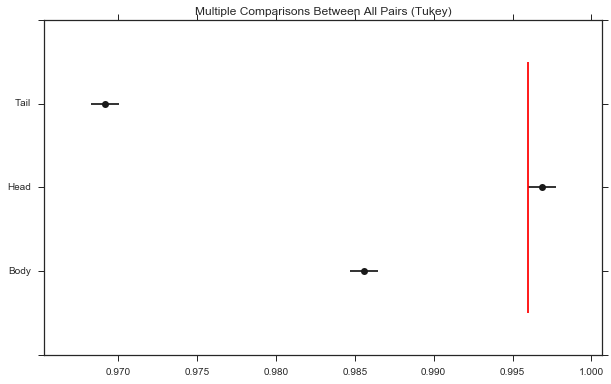

In [27]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=Sample_error.NDCG.values,     # Data
                          groups=Sample_error['Diversity rank'].values,   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
plt.vlines(x=0.996,ymin=-0.5,ymax=2.5, color="red")

tukey.summary()              # See test summary

La respuesta obtenida por el Tukey's test muestra una diferencia promedio, el intervalo de confianza también indica que la hipótesis nula debería ser rechazada para cada par de grupos dado un nivel de significancia. En este caso la prueba sugiere que deberíamos rechazar la hipótesis nula para los 3 pares. Esto sugiere que cada grupo es significativamente diferente de los demás. El 95% de intervalo de confianza refuerza los resultados visualmente: Ningún intervalo de confianza se empalma con ninguno otro intervalo de confianza de los demás.

## Test

De la misma manera se hace todo lo anterior pero ahora sometiendo los 21 días de observación pertenecientes al conjunto de prueba.

In [28]:
test_set['y_'] = est.predict(X_test.values)
test_set['y_rank'] = test_set.groupby('Date')['y_'].rank(ascending=True, method='first')

In [29]:
df2 = test_set.groupby('Date').apply(lambda x: x.sort_values('Rank',ascending=False))
del df2['Date']
df2 = df2.reset_index()

Sample_error = pd.DataFrame({'Diversity rank' : [],'NDCG' : []})

for d in df2.Date.unique():
    rankhead = df2[(df2.Date == d) & (df2['station_arrived'].isin(head))]
    Sample_error = Sample_error.append(pd.DataFrame([['Head', ndcg_at_k(rankhead['y_rank'].tolist(), len(rankhead['y_rank']))]], 
                                                        columns=['Diversity rank','NDCG']),ignore_index=True)
    rankbody = df2[(df2.Date == d) & (df2['station_arrived'].isin(body))]
    Sample_error = Sample_error.append(pd.DataFrame([['Body', ndcg_at_k(rankbody['y_rank'].tolist(), len(rankbody['y_rank']))]], 
                                                        columns=['Diversity rank','NDCG']),ignore_index=True)
    ranktail = df2[(df2.Date == d) & (df2['station_arrived'].isin(tail))]
    Sample_error = Sample_error.append(pd.DataFrame([['Tail', ndcg_at_k(ranktail['y_rank'].tolist(), len(ranktail['y_rank']))]], 
                                                        columns=['Diversity rank','NDCG']),ignore_index=True)

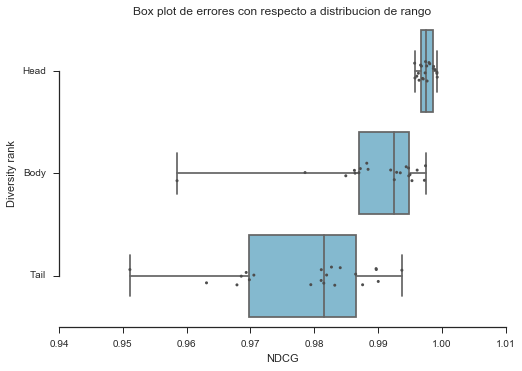

In [30]:
ErrorRank(Sample_error)

group1,group2,meandiff,lower,upper,reject
Body,Head,0.0079,0.002,0.0138,True
Body,Tail,-0.0109,-0.0168,-0.005,True
Head,Tail,-0.0188,-0.0247,-0.0129,True


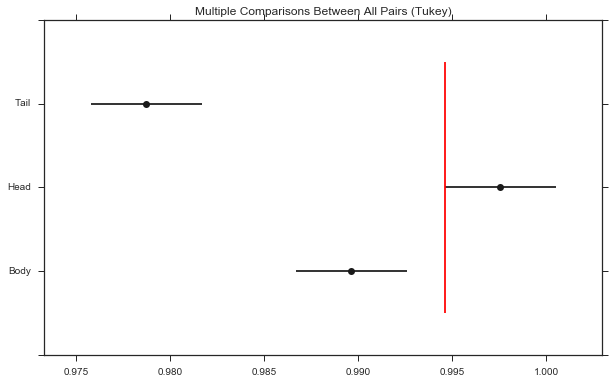

In [31]:
groups = Sample_error.groupby("Diversity rank").groups

# Etract diversity rank groups
NDCG_head = Sample_error.ix[groups["Head"]].NDCG.values
NDCG_body = Sample_error.ix[groups["Body"]].NDCG.values
NDCG_tail = Sample_error.ix[groups["Tail"]].NDCG.values

# Perform the ANOVA
stats.f_oneway(head, body, tail)

tukey = pairwise_tukeyhsd(endog=Sample_error.NDCG.values,     # Data
                          groups=Sample_error['Diversity rank'].values,   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
plt.vlines(x=0.9946,ymin=-0.5,ymax=2.5, color="red")

tukey.summary()              # See test summary

De igual forma la hipótesis nula es rechazada para las 3 categorías, donde las medias en conjunto con sus intervalos de confiansza se encuentran bien separados unos de otros. Es importante hacer notar que el grupo que obtuvo la mejor evaluación de ordenamiento (ranking) fue el subconjunto de head, demostrando que:
- Existe una diferencia entre los errores obtenidos entre las diferentes clases de estaciones.
- Existe una diferencia de resultados obtenidos para cada uno de los grupos evaluados, lo cual implica que los subconjuntos obtenidos por rank diversity se inclinan hacia una mejor evaluación
- Los resultados obtenidos sugieren que las estaciones en el head se encuentran en rangos más estables comparadas con las demás estaciones.

In [32]:
from IPython.display import HTML
#To hide code from the nbviewer render
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')